### imports

In [1]:
from neuralmonkey.classes.session import load_mult_session_helper
from pythonlib.tools.stroketools import strokesInterpolate2
import pythonlib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import random
import math
import os
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2

### Session helper functions

In [3]:
################################################
### Extracting a Session's successful Trialcodes/Trialnums ###
################################################

# get a list of successful trialcodes
def getSuccessfulTrialCodes(sn):
    D = sn.Datasetbeh
    Dcopy = D.copy()
    Dcopy.preprocessGood(params=["one_to_one_beh_task_strokes"]) # prunes Dcopy to keep only successful trials
    
    return Dcopy.Dat['trialcode'].tolist()

# from the list of trialcodes, get matching list of NEURAL trials
def getNeuralTrialNumsFromTrialCodes(sn, trialcode_list):
    D = sn.Datasetbeh
    trials = []
    for tc in trialcode_list:
        # make sure there is exactly one matching trialcode
        #index_dataset = D.Dat[(D.Dat["trialcode"]==tc)].index
        #assert len(index_dataset)==1

        # pull out these datapoints from trial-level dataset
        t = sn.datasetbeh_trialcode_to_trial(tc)
        trials.append(t)
        #ons, offs = sn.strokes_extract_ons_offs(trialtdt)
    return trials

# get a list of successful trialnums
def getSuccessfulNeuralTrialNums(sn):
    trialcodes = getSuccessfulTrialCodes(sn)
    return getNeuralTrialNumsFromTrialCodes(sn, trialcodes)


################################################
### Extracting/Plotting Eye-Tracking Data ###
################################################

# returns smoothed and transformed x,y data for a session/trialnum
def getEyeXYSmoothedAndTransformed(sn, trialnum, PLOT=True):
    # get TRANSFORMED xy-coordinates (used calibration matrix to map to screen)
    st = sn.beh_extract_eye_good(trialnum)
    times = st[0]
    x_aff = st[1][:,0]
    y_aff = st[1][:,1]

    # SMOOTH DATA
    from pythonlib.tools.timeseriestools import smoothDat
    x_aff_sm = smoothDat(x_aff, window_len=10)
    y_aff_sm = smoothDat(y_aff, window_len=10)
    
    if PLOT==True:
        fig, axes = plt.subplots(2,1, figsize=(10, 10))
        # plot smoothed x-data
        axes[0].plot(times,x_aff_sm)
        # plot smoothed y-data
        axes[1].plot(times,y_aff_sm)
        return x_aff_sm, y_aff_sm, times, axes
    else:
        return x_aff_sm, y_aff_sm, times

# plot the (x,y) data over time for eye tracking data
def plotEyeTrackingTrace(times, x_vals, y_vals, ax, color="b"):
    ax.plot(x_vals, y_vals, "-k", alpha=0.3)
    ax.scatter(x_vals, y_vals, c=times, alpha=0.5, marker="o")   
    

# get the start, end times for the window spanned by start_event, end_event
def getTimeWindowOfEvents(sn, trial, start_event, end_event):
    # keep just times between [start_event, end_event]
    dict_event_times = sn.events_get_time_sorted(trial, list_events=(start_event, end_event))[0]
    start_time = dict_event_times[start_event][0]
    end_time = dict_event_times[end_event][0]
    
    return start_time, end_time


# return mask array of whether within bounding box
def getBoundingBoxMask(x, y, minx, miny, maxx, maxy):
    assert len(x) == len(y), "xy must be same length"
    xn = np.array(x)
    yn = np.array(y)

    result = ((xn >= minx) & (xn <= maxx) & (yn >= miny) & (yn <= maxy))
    #print(result)
    return result

## Part 1: export x,y,times,outlier_mask to MATLAB

In [4]:
## LOAD IN SESSION ##

# preprocessed datasets: Diego-230603 (ok), Pancho-221020 (ok), Diego-230626 (primsingrid), Diego-230616 (26 singleprims)
date = 230623
animal = "Pancho"
session = 0

# change to base dir
basedir = "/home/kgg/Desktop/eyetracking_analyses/"
os.chdir(basedir)

# mkdir for animal-date-session
dirn = animal + "-" + str(date) + "-" + str(session)
os.makedirs(dirn, exist_ok=True)
os.chdir(dirn)

# load session
#MS = load_mult_session_helper(date, animal)
MS = load_mult_session_helper(date, animal, MINIMAL_LOADING=True, spikes_version="kilosort")
# loadandconcat snippets === event is fixations
sn = MS.SessionsList[session]

Searching using this string:
/home/kgg/mnt/Freiwald/ltian/recordings/*Pancho*/*230623*/**
Found this many paths:
1
---
/home/kgg/mnt/Freiwald/ltian/recordings/Pancho/230623/Pancho-230623-144906
session:  0
Beh Sessions that exist on this date:  {230623: [(1, 'primsingridfixed6d')]}
------------------------------
Loading this neural session: 0
Loading these beh expts: ['primsingridfixed6d']
Loading these beh sessions: [1]
Using this beh_trial_map_list: [(1, 0)]
Searching using this string:
/home/kgg/mnt/Freiwald/ltian/recordings/*Pancho*/*230623*/**
Found this many paths:
1
---
/home/kgg/mnt/Freiwald/ltian/recordings/Pancho/230623/Pancho-230623-144906
{'filename_components_hyphened': ['Pancho', '230623', '144906'], 'basedirs': ['/home/kgg/mnt/Freiwald/ltian/recordings/Pancho', '/home/kgg/mnt/Freiwald/ltian/recordings/Pancho/230623'], 'basedirs_filenames': ['230623', 'Pancho-230623-144906'], 'filename_final_ext': 'Pancho-230623-144906', 'filename_final_noext': 'Pancho-230623-144906'}
FOu

In [5]:
success_neural_trials = getSuccessfulNeuralTrialNums(sn)
# store valid trialnums
neuraltnums = []
tcodes = []

SAVEMATS=False

# get bounding box
# - format: [[-x, -y], [+x, +y]]. does not save in self
#bounding_box = sn.Datasetbeh.recomputeSketchpadEdgesAll(strokes_ver="strokes_task")
#print(bounding_box)


# loop thru trials and save xy data
for ntrial in success_neural_trials:
    if SAVEMATS==True:
        # get sampling rate
        t,v,fs_raw = sn.extract_data_tank_streams("eyex", ntrial, ploton=False)

        # get XY smoothed / transformed on eye calibration matrix
        x_raw,y_raw,times_raw = getEyeXYSmoothedAndTransformed(sn, ntrial, False)

        # resample x, y, times using integer sampling rate
        fs_new = 200
        stroke_raw = [np.array([x_raw, y_raw, times_raw]).T] # dummy stroke list
        stroke_intp = strokesInterpolate2(stroke_raw, ["fsnew", fs_new, fs_raw])
        stroke_resampled = stroke_intp[0]
        x_rs = stroke_resampled[:,0]
        y_rs = stroke_resampled[:,1]
        times_rs = stroke_resampled[:,2]
        
        # save data to be loaded into MATLAB
        fname = "ntrial" + str(ntrial) + ".mat"
        scipy.io.savemat(fname, dict(x=x_rs, y=y_rs, times=times_rs, fs_hz=fs_new))

    # save neuraltnums, tcodes
    neuraltnums.append(ntrial)
    tcodes.append(sn.datasetbeh_trial_to_trialcode(ntrial))
    



*** RUNNING D.preprocessGood using these params:
['one_to_one_beh_task_strokes']
-- Len of D, before applying this param: one_to_one_beh_task_strokes, ... 708
after: 616


In [6]:
# save trial numbers for later use in MATLAB
scipy.io.savemat("all_ntrialnums.mat", dict(neuraltrialnums=neuraltnums))

# save trialcodes for later use in MATLAB
scipy.io.savemat("all_trialcodes.mat", dict(trialcodes=tcodes))

# Part 2: after running ClusterFix in MATLAB, load in fixation/saccade times 

In [6]:
# load in results
mat = scipy.io.loadmat('clusterfix_results.mat')

In [7]:
# add results to dataframe

mat_vars = ['neuraltrialnum', 'trialcode', 'fs', 'x', 'y', 'times', 'fixation_start_inds',
            'fixation_end_inds', 'fixation_centroids_x', 'fixation_centroids_y', 
            'saccade_start_inds', 'saccade_end_inds']
tmp = []
for i in range(len(mat['RESULTS'][0])):
    neuraltrialnum = mat['RESULTS'][0]['neuraltrialnum'][i][0,0]
    tcode = mat['RESULTS'][0]['trialcode'][i][0]
    fs = mat['RESULTS'][0]['fs'][i][0,0]
    x = mat['RESULTS'][0]['x'][i][0]
    y = mat['RESULTS'][0]['y'][i][0]
    times = mat['RESULTS'][0]['times'][i][0]
    
    # get start, end inds for fixations/saccades
    fixation_start_inds = mat['RESULTS'][0]['fixation_inds'][i][0]
    fixation_end_inds = mat['RESULTS'][0]['fixation_inds'][i][1]
    saccade_start_inds = mat['RESULTS'][0]['saccade_inds'][i][0]
    saccade_end_inds = mat['RESULTS'][0]['saccade_inds'][i][1]
    
    # get centroids x,y
    fixation_centroids_x = mat['RESULTS'][0]['fixation_centroids'][i][0]
    fixation_centroids_y = mat['RESULTS'][0]['fixation_centroids'][i][1]
    
    dat = [neuraltrialnum, tcode, fs, x, y, times, fixation_start_inds, fixation_end_inds,
            fixation_centroids_x, fixation_centroids_y, saccade_start_inds, saccade_end_inds]
    tmp.append({})
    for v, d in zip(mat_vars, dat):
        tmp[-1][v]=d
        
clusterfix_results = pd.DataFrame(tmp, columns=mat_vars)

In [8]:
clusterfix_results

neuraltrialnum      trialcode     fs  \
0                 0     230623-1-1  0.005   
1                 1     230623-1-2  0.005   
2                 2     230623-1-3  0.005   
3                 3     230623-1-4  0.005   
4                 4     230623-1-5  0.005   
..              ...            ...    ...   
611            1033  230623-1-1034  0.005   
612            1035  230623-1-1036  0.005   
613            1036  230623-1-1037  0.005   
614            1038  230623-1-1039  0.005   
615            1039  230623-1-1040  0.005   

                                                     x  \
0    [-199.070316702116, -196.45790299897874, -235....   
1    [-39.669147605668186, -44.60166595965158, -41....   
2    [221.76047699302157, 224.59605422582786, 223.4...   
3    [604.1637956482454, 540.2387939205607, 480.615...   
4    [1463.4436613768798, 1464.8178908216635, 1463....   
..                                                 ...   
611  [-26.793046130920047, -28.86435285558813, -28....   
612  [-86.71262279475516, -90.83448330831875, -86.6...   
613  [-46.673906393697365, -47.13943139955895, -48....   
614  [703.9338049192565, 705.0529544674296, 703.446...   
615  [-59.27070344281018, -63.96930551936367, -61.0...   

                                                     y  \
0    [-160.06222822861773, -151.7431679277271, -130...   
1    [-40.34315957770101, -44.19316060523777, -41.5...   
2    [603.3626197198428, 604.5013155591888, 602.879...   
3    [262.12316290370387, 234.55685554706392, 215.2...   
4    [716.5581332616165, 717.9347229563223, 716.654...   
..                                                 ...   
611  [-135.6419475473977, -137.85738860666902, -137...   
612  [298.8432586598017, 295.86025296604066, 296.45...   
613  [-203.16443496264753, -203.47577345240197, -20...   
614  [499.3533154613447, 499.81102408573486, 498.57...   
615  [135.95465376333942, 133.41404770337178, 134.3...   

                                                 times  \
0    [-1.0054822681489064, -1.0004795857798243, -0....   
1    [-0.9999244627946666, -0.9949217698205517, -0....   
2    [-1.0003763939032098, -0.9953756701686871, -0....   
3    [-1.0003223750711783, -0.9953198761400119, -0....   
4    [-1.0019398563291304, -0.9969382680655258, -0....   
..                                                 ...   
611  [-0.9998449092508963, -0.994843078950933, -0.9...   
612  [-0.9992885227875377, -0.9942878542792559, -0....   
613  [-1.0000288163391815, -0.9950271002675987, -0....   
614  [-0.9993343476271548, -0.9943336960308231, -0....   
615  [-0.9994242818411294, -0.9944231682193915, -0....   

                                   fixation_start_inds  \
0    [7, 50, 106, 144, 211, 311, 347, 458, 582, 623...   
1    [72, 128, 233, 266, 322, 485, 517, 704, 734, 7...   
2    [4, 30, 83, 150, 198, 273, 391, 694, 732, 770,...   
3    [17, 86, 140, 183, 282, 326, 384, 486, 518, 68...   
4    [21, 51, 103, 145, 195, 237, 471, 503, 712, 75...   
..                                                 ...   
611  [4, 48, 121, 189, 274, 328, 383, 774, 827, 843...   
612  [4, 115, 161, 256, 382, 426, 487, 556, 614, 73...   
613  [4, 22, 61, 118, 193, 253, 319, 365, 810, 842,...   
614  [4, 62, 119, 170, 215, 272, 313, 388, 427, 473...   
615  [73, 114, 308, 389, 432, 534, 573, 748, 809, 8...   

                                     fixation_end_inds  \
0    [36, 90, 131, 188, 292, 336, 448, 570, 612, 65...   
1    [116, 215, 252, 311, 474, 506, 694, 723, 769, ...   
2    [20, 61, 136, 182, 260, 383, 681, 723, 760, 79...   
3    [72, 124, 170, 272, 317, 375, 475, 507, 670, 7...   
4    [37, 91, 129, 185, 216, 460, 494, 698, 744, 77...   
..                                                 ...   
611  [34, 107, 164, 263, 314, 375, 762, 815, 836, 8...   
612  [104, 152, 242, 351, 416, 478, 546, 603, 708, ...   
613  [8, 46, 110, 174, 229, 307, 351, 756, 834, 891...   
614  [44, 99, 157, 200, 256, 296, 376, 409, 460, 50...   
615  [101, 293, 380, 425, 523, 561, 73

### save saccade, fixation onsets/offsets into .csv to be loaded by neuralmonkey/session.py

In [10]:
from numpy import savetxt

#for i in range(len(neuraltnums)):
for index, row in clusterfix_results.iterrows():
    tnum = row['neuraltrialnum']
    print("tnum", tnum)
    tcode = row['trialcode']
    print("tcode", tcode)
    
    x_t = row['x']
    y_t = row['y']
    times_t = row['times']
    
    # get the FIXATIONS belonging to this trial
    fixation_start_inds = row['fixation_start_inds']
    fixation_end_inds = row['fixation_end_inds']
    fixation_centroids_x = row['fixation_centroids_x']
    fixation_centroids_y = row['fixation_centroids_y']
    centroid_pairs = [[x,y] for x,y in zip(fixation_centroids_x, fixation_centroids_y)]
    
    # get the times of the FIXATIONS
    fixation_start_times = times_t[fixation_start_inds]
    fixation_end_times = times_t[fixation_end_inds]
    print("fixation start times", fixation_start_times)
    print("fixation end times", fixation_end_times)

    # TODO: remove any fixations that contain outlier times... (must compute bounding box)
        
    # save fixation start times using TRIALCODE, to load into session.py
    fname = f"{tcode}-fixation-onsets.csv"
    savetxt(fname, fixation_start_times, delimiter=',')
    
    # save fixation centroids using TRIALCODE, to load into session.py
    fname = f"{tcode}-fixation-centroids.csv"
    savetxt(fname, centroid_pairs, delimiter=",")
        
    # get the times of the SACCADES
    saccade_start_inds = row['saccade_start_inds']
    saccade_end_inds = row['saccade_end_inds']
    saccade_start_times = times_t[saccade_start_inds]
    saccade_end_times = times_t[saccade_end_inds]
    
    print("saccade start times", saccade_start_times)
    print("saccade end times", saccade_end_times)
    
    # TODO: remove any saccades that contain outlier times
    
    # save saccade start times using TRIALCODE, to load into session.py
    fname = f"{tcode}-saccade-onsets.csv"
    savetxt(fname, saccade_start_times, delimiter=',')

tnum 0
tcode 230623-1-1
fixation start times [-0.97046349 -0.75534815 -0.47519794 -0.28509601  0.05008371  0.55035195
  0.73044851  1.28574626  1.90607887  2.11118885  2.33630955  2.51640612
  2.84658316  3.05669582  3.30682993  3.49693186  3.67702843  3.83711427
  4.1672913   4.38740933  5.20284655  5.42296458  5.57304505  6.02828914
  6.21839107  6.39348496  6.53856274  7.17890609  7.45405362  8.08939428]
fixation end times [-0.8253857  -0.55524085 -0.35013088 -0.06497798  0.45530098  0.67541901
  1.23571943  1.84604668  2.05615934  2.28628273  2.46137661  2.79655633
  3.01167167  3.24679775  3.43689968  3.63200429  3.77207939  4.12726984
  4.34238518  5.16782778  5.36293239  5.51801554  5.97325964  6.1533562
  6.30843936  6.46352251  7.09886317  7.39402143  8.02936209  8.3095123 ]
saccade start times [-1.00047959 -0.82038302 -0.54523549 -0.3451282  -0.0599753   0.46030367
  0.68542437  1.24072212  1.85104936  2.06116202  2.2962881   2.4663793
  2.80155901  3.01667436  3.25180043  3.

saccade start times [-0.93512624 -0.71499551 -0.3847994  -0.19968946  0.12550368  0.35063739
  0.62079784  0.80090481  0.98601475  2.62698934  2.93717356  3.14229539
  3.38243801  3.77266978  4.35301445  4.51310953  4.84330564  5.15348986
  5.62376917  5.96897419  6.56432778  7.02460114  7.27474971  7.44485073
  7.85009141]
saccade end times [-0.86508465 -0.57491231 -0.33977266 -0.11964192  0.20054825  0.4006671
  0.6808335   0.86094046  1.0460504   2.67701906  2.97219436  3.18732213
  3.44247367  3.82269949  4.38803525  4.53812439  4.87332347  5.21852849
  5.67379888  6.0190039   6.61435749  7.09964571  7.32978239  7.50988936
  7.94014489]
tnum 174
tcode 230623-1-175
fixation start times [-0.89514283 -0.66501258 -0.48491065 -0.05966998  0.41059618  0.68074908
  1.3211115   1.53123042  2.17659568  2.5618137   2.84197227  3.06209685
  3.32724692  3.61240831  3.71746777  4.18773393  4.48790381  4.92315015
  5.09824925  5.30336534  5.52348992  5.81865698  6.08880988  6.79420911
  7.599664

saccade start times [-0.79991445 -0.57984271 -0.24473346  0.02035296  2.42113565  2.61119761
  2.92129871  3.10635904  3.32142916  3.51149112  3.71655797  4.17670799
  4.3267569   4.51181724  4.72688735  4.9469591   5.35709281  5.64718738
  5.88726565  6.0923325   6.32740914  6.9576146   7.47278255  7.69785592
  8.01295865  8.2980516   8.45310214  8.79321302  9.06330108  9.52345109]
saccade end times [-0.72989162 -0.51482151 -0.20972204  0.13539047  2.48615685  2.64620903
  2.97131501  3.17138024  3.37644709  3.55150416  3.76157265  4.20671777
  4.35676669  4.54182702  4.78690692  5.00197703  5.44712216  5.72221184
  5.93228033  6.16735696  6.42244012  7.01763416  7.53280211  7.78788528
  8.05797333  8.38808095  8.50812008  8.83322607  9.10331412  9.5584625 ]
tnum 437
tcode 230623-1-438
fixation start times [-0.97964812 -0.62949613  0.18585779  2.37180663  2.54188046  2.79699119
  2.97706936  3.18716055  3.3522322   3.84744716  4.28263606  5.17802471
  5.32308768  5.84331349  6.0984242

fixation start times [-0.93938266 -0.62429247 -0.31420372  0.21094658  0.56604822  1.04118421
  1.61634883  2.37156498  4.25710465  6.07262428  6.39271589  6.57776886
  6.76782325  6.95787765  7.8231253   8.58834431  8.83841589  9.59863347
  9.81869646 10.48888827 10.70394983 11.03904574 11.24910586 11.35413592
 11.70923755 11.87428479]
fixation end times [-0.68931108 -0.37922233  0.14092654  0.52603677  0.7210926   1.56633452
  2.3265521   4.13206886  6.00260424  6.32769728  6.51275025  6.71780894
  6.9028619   7.77811241  8.54333143  8.75839298  9.54361772  9.75867928
 10.40386394 10.66393838 10.94901997 11.17408439 11.28911731 11.61421036
 11.80426475 12.07434205]
saccade start times [-0.68430965 -0.3742209   0.14592798  0.5310382   0.72609403  1.57133595
  2.33155353  4.1370703   6.00760567  6.33269871  6.51775168  6.72281037
  6.91286477  7.78311384  8.54833286  8.76839585  9.54861916  9.76368071
 10.40886537 10.66893981 10.95902283 11.17908582 11.29411874 11.61921179
 11.80926618

# Part 3: extract Snippets, and plot rasters etc.

In [8]:
from neuralmonkey.classes.snippets import Snippets, extraction_helper

# Turn on debug mode, this prunes sites and trials, so below runs faster
DEBUG = False
sn._DEBUG_PRUNE_SITES = DEBUG
sn._DEBUG_PRUNE_TRIALS = DEBUG

In [9]:
# if switching from debug to not debug, run this
#sn.PopAnalDict = {}

In [10]:
if DEBUG:
    # option1 - get first 5 trials, to test
    dataset_pruned_for_trial_analysis = sn.Datasetbeh.copy()
    dataset_pruned_for_trial_analysis.Dat = dataset_pruned_for_trial_analysis.Dat.iloc[0:5]
else:
    # option2 - get all trialcodes from tcodes
    dataset_pruned_for_trial_analysis = sn.Datasetbeh.copy()
    dataset_pruned_for_trial_analysis.Dat = dataset_pruned_for_trial_analysis.Dat[dataset_pruned_for_trial_analysis.Dat["trialcode"].isin(tcodes)].reset_index(drop=True)

In [11]:
# Main code for extracting Snippets (SP)

# # == MODIFY THESE:
list_events = ["fixon"] # each event defines a snippet
list_pre_dur = [-0.5]
list_post_dur = [0.5]

# == MODIFY THESE:
# list_events = ["go"] # each event defines a snippet
# list_pre_dur = [-0.5]
# list_post_dur = [0.5]

# == IGNORE THESE:
which_level = "flex"
list_features_extraction = []
list_features_get_conjunction = []
trials_prune_just_those_including_events=False
fail_if_times_outside_existing=False

SP = Snippets(sn,
    which_level,
    list_events,
    list_features_extraction,
    list_features_get_conjunction,
    list_pre_dur,
    list_post_dur,
    strokes_only_keep_single=False,
    tasks_only_keep_these=None,
    prune_feature_levels_min_n_trials=None,
    dataset_pruned_for_trial_analysis=dataset_pruned_for_trial_analysis,
    trials_prune_just_those_including_events=trials_prune_just_those_including_events,
    fr_which_version='sqrt',
    NEW_VERSION=True,
    SKIP_DATA_EXTRACTION=False,
    fail_if_times_outside_existing=fail_if_times_outside_existing
             )


 == extarcating these sites:  [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1265, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1266, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 11

In [41]:
SP.datasetbeh_preprocess_clean_by_expt(ANALY_VER='MINIMAL', vars_extract_append=[])

Done!, new len of dataset 708
Starting length of D.Dat: 708
--BEFORE REMOVE; existing supervision_stage_concise:
off|0||1111|0    708
Name: supervision_stage_concise, dtype: int64
############ TAKING ONLY NO SUPERVISION TRIALS
*** RUNNING D.preprocessGood using these params:
['no_supervision']
-- Len of D, before applying this param: no_supervision, ... 708
after: 708
Dataset final len: 708
Starting len dfscalar:  532744
Ending len dfscalar:  532744


(<pythonlib.dataset.dataset.Dataset at 0x7f02ebde65c0>, [])

In [ ]:
# to save snippet:
SP.save_v2()

# to load snippet:
load_snippet_single()

# run this AFTER loading snippet (throws out trials, so use this in ANALYSES, and DON'T SAVE THIS)
SP.datasetbeh_preprocess_clean_by_expt(ANALY_VER='MINIMAL', vars_extract_append=[])
# TODO: add filter for 'prims_on_grid' in col task_kind 

### Helper functions

In [12]:
# array of tokens, each one is a task stroke with info such as shapename etc.
def getAllTaskStrokeTokens(sn, trial):
    dataset_index_from_neural = sn.datasetbeh_trial_to_datidx(trial)
    return sn.Datasetbeh.taskclass_tokens_extract_wrapper(dataset_index_from_neural, "task", plot=False)

############
## SHAPES ##
############
def getShapesInOrder(sn, trial):
    ts = getAllTaskStrokeTokens(sn, trial)

    shape_names = []
    for i, t in enumerate(ts):
        shape_name = t['shape'] + '-' + str(i) # adds unique tag onto it, so same shape is named differently
        shape_names.append(t['shape'])
    
    return shape_names

def getShapeCentroidsInOrder(sn, trial):
    shape_coords = sn.strokes_task_extract(trial)
    shape_names = getShapesInOrder(sn, trial)
    shape_centroids = {}
    for i in range(len(shape_names)):
        name = shape_names[i]
        centroid = [np.mean(shape_coords[i][:,0]), np.mean(shape_coords[i][:,1])]
        #print("name", name)
        #print("centroid", centroid)
        shape_centroids[name] = centroid
        
    return shape_centroids # returns dict {name: [x,y]}

def getClosestShapeToCentroid(sn, trial, centroid):
    x = centroid[0]
    y = centroid[1]
    shapeDict = getShapeCentroidsInOrder(sn, trial)
    distances = []
    names = []
    
    for name in shapeDict:
        names.append(name)
        distances.append(math.dist(shapeDict[name], [x,y]))
    
    shape_ind = np.argmin(distances)
    return names[shape_ind]

    # TODO: change to use threshold (could be looking at go cue..) 
    
###############
## LOCATIONS ##
###############
def getLocationsAndCentroidsInOrder(sn, trial):
    ts = getAllTaskStrokeTokens(sn, trial)

    loc_names = []
    loc_coords = []
    for t in ts:
        loc_names.append(str(t['gridloc']))
        loc_coords.append(t['center'])
    
    return loc_names, loc_coords
    

def getClosestLocToCentroid(sn, trial, centroid):
    x = centroid[0]
    y = centroid[1]
    locs = getLocationsAndCentroidsInOrder(sn, trial)
    locNames = locs[0]
    locCentroids = locs[1]
    
    distances = []
    names = []
    
    for i, name in enumerate(locNames):
        names.append(name)
        distances.append(math.dist(locCentroids[i], [x,y]))
    
    loc_ind = np.argmin(distances)
    return str(names[loc_ind])

    # TODO: change to use threshold (could be looking at go cue..)

### add various columns to analyze

In [15]:
# add drawing sequence information directly to SP

D = SP.SN.Datasetbeh
D.seqcontext_preprocess()
SP.datasetbeh_append_column("seqc_0_shape", D)
SP.datasetbeh_append_column("seqc_0_loc", D)
SP.datasetbeh_append_column("seqc_1_shape", D)
SP.datasetbeh_append_column("seqc_1_loc", D)
SP.datasetbeh_append_column("seqc_2_shape", D)
SP.datasetbeh_append_column("seqc_2_loc", D)
SP.datasetbeh_append_column("seqc_3_shape", D)
SP.datasetbeh_append_column("seqc_3_loc", D)

SP.datasetbeh_append_column_helper(["task_kind"])

# ONLY RUN ONCE...
dummy_df = SP.DfScalar.copy()

In [171]:
from pythonlib.tools.pandastools import append_col_with_grp_index

dummy_df = append_col_with_grp_index(dummy_df, ['seqc_0_shape', 'seqc_1_shape', 'seqc_2_shape'], 'shape-drawing-sequence', strings_compact=True)

In [102]:
dummy_df['shape-drawing-sequence'].value_counts()

arcdeep-4-1-0|IGNORE|IGNORE|IGNORE                  502274
Lcentered-4-3-0|IGNORE|IGNORE|IGNORE                475627
V-2-2-0|IGNORE|IGNORE|IGNORE                        465859
line-8-4-0|Lcentered-4-3-0|arcdeep-4-1-0|V-2-2-0    439888
line-8-4-0|arcdeep-4-1-0|Lcentered-4-3-0|V-2-2-0    385653
line-8-4-0|IGNORE|IGNORE|IGNORE                     370971
Lcentered-4-3-0|line-8-4-0|arcdeep-4-1-0|V-2-2-0    369837
Lcentered-4-3-0|arcdeep-4-1-0|line-8-4-0|V-2-2-0    288073
arcdeep-4-1-0|Lcentered-4-3-0|line-8-4-0|V-2-2-0    284915
arcdeep-4-1-0|line-8-4-0|Lcentered-4-3-0|V-2-2-0    257244
Lcentered-4-3-0|arcdeep-4-1-0|V-2-2-0|line-8-4-0    204863
line-8-4-0|arcdeep-4-1-0|V-2-2-0|Lcentered-4-3-0    204764
line-8-4-0|V-2-2-0|Lcentered-4-3-0|arcdeep-4-1-0    194607
line-8-4-0|V-2-2-0|arcdeep-4-1-0|Lcentered-4-3-0    181314
arcdeep-4-1-0|Lcentered-4-3-0|V-2-2-0|line-8-4-0    167258
line-8-4-0|Lcentered-4-3-0|V-2-2-0|arcdeep-4-1-0    163729
arcdeep-4-1-0|line-8-4-0|V-2-2-0|Lcentered-4-3-0    1541

In [16]:
# whether each fixation is within event window (e.g. [stim_onset, go])
# also early-or-late-planning-period
# also normalized time

neuraltrials = dummy_df['trial_neural'].unique()

for nt in neuraltrials:
    # get time window
    start_time, end_time = getTimeWindowOfEvents(sn, nt, "stim_onset", "go")
    middle_time = np.mean([start_time, end_time])
    
    event_inds_within_trial = dummy_df[dummy_df['trial_neural']==nt]['event_idx_within_trial'].unique()
    
    for eind in event_inds_within_trial:
        e_df_inds = dummy_df.index[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
        e_df_temp = dummy_df[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
    
        # now, see whether this falls in between [stim_onset, go]
        e_time = e_df_temp.iloc[0]['event_time']

        if (e_time >= start_time) and (e_time <= end_time):
            dummy_df.loc[e_df_inds, 'between_stim-onset_and_go'] = True
            dummy_df.loc[e_df_inds, 'event_time_normalized_planning'] = (e_time-start_time)/(start_time-end_time)
            if (e_time <= middle_time):
                dummy_df.loc[e_df_inds, 'early-or-late-planning-period'] = 'early'
            else:
                dummy_df.loc[e_df_inds, 'early-or-late-planning-period'] = 'late'
        else:
            dummy_df.loc[e_df_inds, 'between_stim-onset_and_go'] = False
            dummy_df.loc[e_df_inds, 'event_time_normalized_planning'] = -1
            dummy_df.loc[e_df_inds, 'early-or-late-planning-period'] = 'IGNORE'

In [17]:
# closest shape fixation, and whether it is the first fixation on that shape

neuraltrials = dummy_df['trial_neural'].unique()

for nt in neuraltrials:
    
    event_inds_within_trial = dummy_df[dummy_df['trial_neural']==nt]['event_idx_within_trial'].unique()
    
    for eind in event_inds_within_trial:
        e_df_inds = dummy_df.index[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
        e_df_temp = dummy_df[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
        
        # first, get centroid of this fixation event
        e_cntrd = e_df_temp.iloc[0]['fixation-centroid']
        
        # now, get closest shape to this centroid and add to dummy_df
        shapefix = getClosestShapeToCentroid(sn, nt, e_cntrd)
        dummy_df.loc[e_df_inds, 'shape-fixation'] = shapefix
        
        # now, see whether this is the FIRST fixation on this shape
        if eind==event_inds_within_trial[0]:
            dummy_df.loc[e_df_inds, 'first-fixation-on-shape'] = True #TODO: fix if want first in WINDOW, not overall
            dummy_df.loc[e_df_inds, 'prev-shape-fixation'] = 'IGNORE'
        else:
            # check if shape for previous eind is the same
            e_prev_df_temp = dummy_df[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==(eind-1))]
            shape_prev = e_prev_df_temp.iloc[0]['shape-fixation']
            dummy_df.loc[e_df_inds, 'prev-shape-fixation'] = shape_prev # NOTE: if microsaccade, shape_prev is same shape...
            # better approach if want previous shape category: get max index of first-fixation-on-shape==True that is less than current...
            
            if shape_prev == shapefix:
                dummy_df.loc[e_df_inds, 'first-fixation-on-shape'] = False
            else:
                dummy_df.loc[e_df_inds, 'first-fixation-on-shape'] = True
                
# TODO: rename first-fixation-on-shape to first-saccade-to-shape

In [119]:
dummy_df['shape-macrosaccade-index'].value_counts()

-1.0    5293196
 1.0      98691
 2.0      98690
 3.0      97379
 4.0      91527
 5.0      71246
 6.0      44025
 7.0      17875
 8.0       3733
 9.0        800
Name: shape-macrosaccade-index, dtype: int64

In [225]:
# shape-macrosaccade-index, and loc-macrosaccade-index

neuraltrials = dummy_df['trial_neural'].unique()

for nt in neuraltrials:
    
    event_inds_within_trial = dummy_df[dummy_df['trial_neural']==nt]['event_idx_within_trial'].unique()
    
    # start counter, for first-fixation-on-shape
    counter = 1
    macrosacc_seq_shape = []
    macrosacc_seq_loc = []
    
    for eind in event_inds_within_trial:
        e_df_inds = dummy_df.index[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
        e_df_temp = dummy_df[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
        
        # number off first-fixation-on-shapes
        if e_df_temp.iloc[0]['between_stim-onset_and_go'] == True and e_df_temp.iloc[0]['first-fixation-on-shape'] == True:
            dummy_df.loc[e_df_inds, 'shape-macrosaccade-index'] = counter
            if counter<=3:
                macrosacc_seq_shape.append(e_df_temp.iloc[0]['shape-fixation'])
            if counter<=2:
                macrosacc_seq_loc.append(e_df_temp.iloc[0]['loc-fixation'])
            counter += 1
        else:
            dummy_df.loc[e_df_inds, 'shape-macrosaccade-index'] = -1 # when filtering out first-fixation-on-shape==False, will be remove
    
    dummy_df.loc[dummy_df.index[dummy_df['trial_neural']==nt], 'shape-macrosaccade-sequence'] = '|'.join(macrosacc_seq_shape)
    dummy_df.loc[dummy_df.index[dummy_df['trial_neural']==nt], 'loc-macrosaccade-sequence'] = '|'.join(macrosacc_seq_loc)

In [217]:
def trimSequenceString(col):
    results = []
    for item in col:
        old_strs = item.split('|')
        new_strs = []
        for s in old_strs:
            new_strs.append(s[0:3])
        results.append('|'.join(new_strs))
    return results

dummy_df['shape-macrosaccade-sequence-pruned'] = trimSequenceString(dummy_df['shape-macrosaccade-sequence'])
#dummy_df['loc-macrosaccade-sequence-pruned'] = trimSequenceString(dummy_df['loc-macrosaccade-sequence'])
dummy_df['shape-drawing-sequence-pruned'] = trimSequenceString(dummy_df['shape-drawing-sequence'])

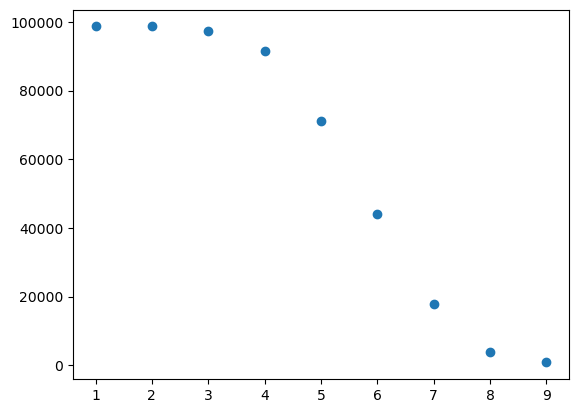

In [34]:
# macrosaccades (between shapes) within planning period
ddd = dummy_df['shape-macrosaccade-index'].value_counts()
x = ddd.keys()
y = ddd.tolist()
plt.scatter(x[1:],y[1:])

In [ ]:
# add whether seen-this-shape (just need T/F since will conjunct on shape-fixation to make mod plots)

neuraltrials = dummy_df['trial_neural'].unique()

for nt in neuraltrials:
    
    event_inds_within_trial = dummy_df[dummy_df['trial_neural']==nt]['event_idx_within_trial'].unique()
    shapes_seen = []
    
    for eind in event_inds_within_trial:
        e_df_inds = dummy_df.index[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
        e_df_temp = dummy_df[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
    
        # now, get shape fixed on
        e_shapefix = e_df_temp.iloc[0]['shape-fixation']

        if e_shapefix in shapes_seen:
            dummy_df.loc[e_df_inds, 'seen-this-shape-in-trial'] = True
        else:
            dummy_df.loc[e_df_inds, 'seen-this-shape-in-trial'] = False
            shapes_seen.append(e_shapefix)

In [19]:
# closest loc fixation, and whether it is the first fixation on that loc

neuraltrials = dummy_df['trial_neural'].unique()

for nt in neuraltrials:
    
    event_inds_within_trial = dummy_df[dummy_df['trial_neural']==nt]['event_idx_within_trial'].unique()
    
    for eind in event_inds_within_trial:
        e_df_inds = dummy_df.index[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
        e_df_temp = dummy_df[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
        
        # first, get centroid of this fixation event
        e_cntrd = e_df_temp.iloc[0]['fixation-centroid']
        
        # get closest location to this centroid and add to dummy_df (implement helper functions)
        locfix = getClosestLocToCentroid(sn, nt, e_cntrd)
        dummy_df.loc[e_df_inds, 'loc-fixation'] = locfix
        
        # now, see whether this is the FIRST fixation on this location
        if eind==event_inds_within_trial[0]:
            dummy_df.loc[e_df_inds, 'first-fixation-on-loc'] = True
        else:
            # check if shape for previous eind is the same
            e_prev_df_temp = dummy_df[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==(eind-1))]
            loc_prev = e_prev_df_temp.iloc[0]['loc-fixation']
            
            if loc_prev == locfix:
                dummy_df.loc[e_df_inds, 'first-fixation-on-loc'] = False
            else:
                dummy_df.loc[e_df_inds, 'first-fixation-on-loc'] = True

In [20]:
# add fixated-on-seqN-shape as Boolean column
# is row['shape-fixation'] == row['seqc_0_shape']

neuraltrials = dummy_df['trial_neural'].unique()

for nt in neuraltrials:
    
    event_inds_within_trial = dummy_df[dummy_df['trial_neural']==nt]['event_idx_within_trial'].unique()
    
    for eind in event_inds_within_trial:
        e_df_inds = dummy_df.index[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
        e_df_temp = dummy_df[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
    
        shapefix = e_df_temp.iloc[0]['shape-fixation']
        
        # now, get N=0,1,2,3 shape
        shape0 = e_df_temp.iloc[0]['seqc_0_shape']
        shape1 = e_df_temp.iloc[0]['seqc_1_shape']
        shape2 = e_df_temp.iloc[0]['seqc_2_shape']
        shape3 = e_df_temp.iloc[0]['seqc_3_shape']

        # add to bool col
        dummy_df.loc[e_df_inds, 'seqc_0_shape'] = shape0
        dummy_df.loc[e_df_inds, 'fixated-on-seq0-shape'] = (shapefix==shape0)
        dummy_df.loc[e_df_inds, 'seqc_1_shape'] = shape1
        dummy_df.loc[e_df_inds, 'fixated-on-seq1-shape'] = (shapefix==shape1)
        dummy_df.loc[e_df_inds, 'seqc_2_shape'] = shape2
        dummy_df.loc[e_df_inds, 'fixated-on-seq2-shape'] = (shapefix==shape2)
        dummy_df.loc[e_df_inds, 'seqc_3_shape'] = shape3
        dummy_df.loc[e_df_inds, 'fixated-on-seq3-shape'] = (shapefix==shape3)

In [ ]:
# add saccade direction angle
# trigonometry using saccade onset LOCATION, and subsequent fixation onset LOCATION

neuraltrials = dummy_df['trial_neural'].unique()

for nt in neuraltrials:
    event_inds_within_trial = dummy_df[dummy_df['trial_neural']==nt]['event_idx_within_trial'].unique()
    shapes_left_in_trial = getShapesInOrder(sn, nt)
    
    for eind in event_inds_within_trial:       
        e_df_inds = dummy_df.index[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
        e_df_temp = dummy_df[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
        
        if eind==event_inds_within_trial[0]: # first fixation has no direction..
            dummy_df.loc[e_df_inds, 'saccade-direction-angle'] = 0 # better placeholder value?
            continue
    
        # now, get fixation centroid
        e_fix_centroid = e_df_temp.iloc[0]['fixation-centroid']
        x = e_fix_centroid[0]
        y = e_fix_centroid[1]
        
        # and same for previous EVENT IDX
        e_df_inds_prev = dummy_df.index[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind-1)]
        e_df_temp_prev = dummy_df[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind-1)]
        e_fix_centroid_prev = e_df_temp_prev.iloc[0]['fixation-centroid']
        x_prev = e_fix_centroid_prev[0]
        y_prev = e_fix_centroid_prev[1]
        
        # add angle
        dummy_df.loc[e_df_inds, 'saccade-direction-angle'] = math.atan2((y-y_prev), (x-x_prev))+math.pi # make between 0-360

# bin saccade direction into 4 quadrants
dummy_df['saccade-direction-angle-bin'] = pd.cut(dummy_df['saccade-direction-angle'], bins=4, labels=["quadrant1", "quadrant2", "quadrant3", "quadrant4"])

# Plotting drawing/looking sequences in rasters

#### goal: want to see if there is noticeable sign of "planning" or "visual response" to macrosaccades [1:4] in PMv, vlPFC
- maybe PMv activity ramps up, vlPFC activity temporarily spikes

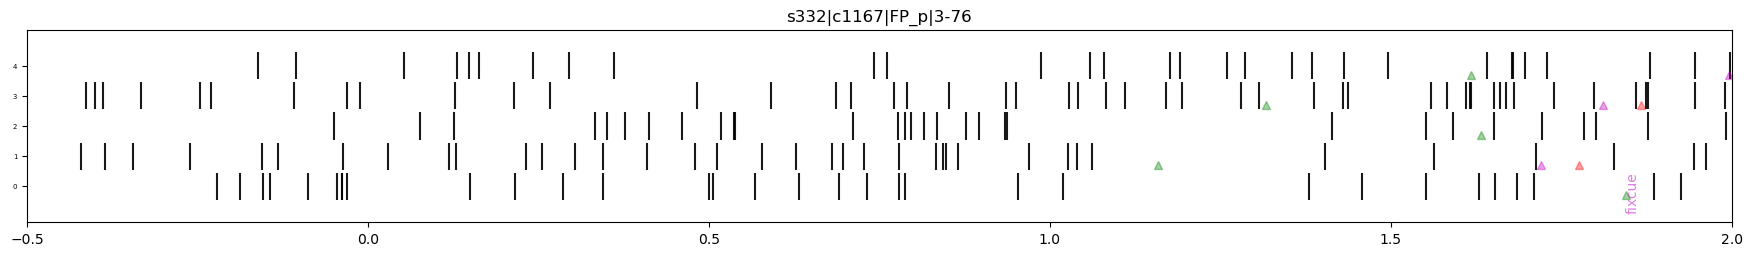

In [222]:
# hack: plot 5 trials in FP
sn2 = MS.SessionsList[0]
site=sn2.sitegetterKS_map_region_to_sites('FP_p')[1]
trials=sn2.get_trials_list(True)[:5]
fig, axes, fig_draw, axes_draw = sn2.plotwrapper_raster_multrials_onesite(list_trials=trials, site=site, alignto='fixon', plot_beh=False,
                                        SIZE=0.5, xmin=-0.5, xmax=2, overlay_trial_events=True)

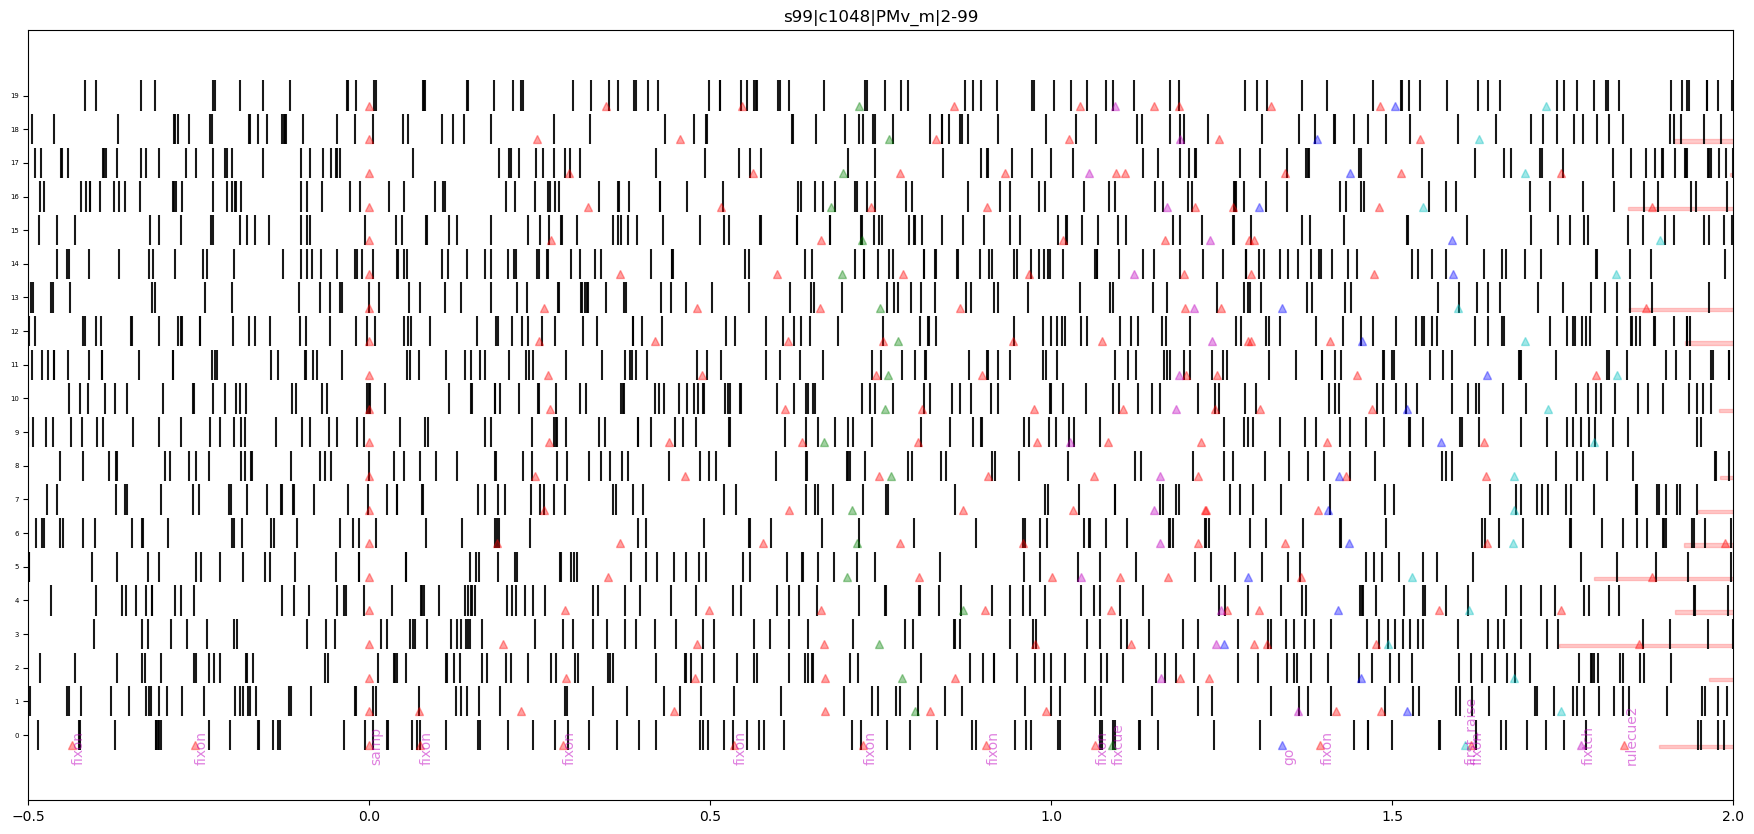

In [223]:
# hack: plot 20 trials in PMv_m, and ALSO overlay fixation events
sn2 = MS.SessionsList[0]
site=sn2.sitegetterKS_map_region_to_sites('PMv_m')[2]
trials=sn2.get_trials_list(True)[:20]
which_events = ["key_events_correct", "fixon"]
fig, axes, fig_draw, axes_draw = sn2.plotwrapper_raster_multrials_onesite(list_trials=trials, site=site, alignto='samp', plot_beh=False,
                                        SIZE=0.5, xmin=-0.5, xmax=2, overlay_trial_events=True, which_events=which_events)


sn2.plotmod_overlay_trial_events_mult(axes.flatten()[0], trials, list_align_time=[0 for _ in range(len(trials))],
                                     xmin=-0.5, xmax=2)

# conclusion: difficult to visualize macrosaccade 1,2,3 because their timing is variable across trials.
# so, will plot individual rasters for each macrosaccade

## Rasters based on shape-drawing-sequence, shape-macrosaccade-sequence

In [212]:
# hold LOOKING seq constant, vary DRAWING seq

SP.DfScalar = dummy_df.copy()
SP.DfScalar = dummy_df[(dummy_df['between_stim-onset_and_go']==True) & (dummy_df['first-fixation-on-shape']==True) & (dummy_df['task_kind']=='prims_on_grid')].reset_index(drop=True)
# get shape-macrosaccade-sequences, which match above parameters
macrosacc_seqs = SP.DfScalar['shape-macrosaccade-sequence-pruned'].unique()

# plotting vars
var = 'shape-drawing-sequence-pruned'
vars_conjuction = ['shape-macrosaccade-index']
score_ver="r2_maxtime_1way_mshuff"
get_z_score=False
event = '00_fixon'

# loop through every macrosaccade sequence
for seq in macrosacc_seqs:
    # first prune dataframe and save
    SP.DfScalar = dummy_df[(dummy_df['shape-macrosaccade-sequence-pruned']==seq) & (dummy_df['shape-macrosaccade-index']<=4)
                           & (dummy_df['shape-macrosaccade-index']>=0) & (dummy_df['between_stim-onset_and_go']==True)
                           & (dummy_df['first-fixation-on-shape']==True) & (dummy_df['task_kind']=='prims_on_grid')].reset_index(drop=True)
    SP.DfScalar['event'] = dummy_df['event']
    SP.DfScalar['event_aligned'] = dummy_df['event']
    
    # then make directory for specific lookng sequence
    sdir_rasters = f"/tmp/sequence-raster-test/VAR_{var}-OV_{'_'.join(vars_conjuction)}/rasters/{event}/looking/{seq}"
    os.makedirs(sdir_rasters, exist_ok=True)

    for br in ['vlPFC_a', 'PMv_m']:
        sites = SP.sitegetter_map_region_to_sites(br)
        for site in sites:
            path = f"{sdir_rasters}/{sn.sitegetter_summarytext(site)}.png"
            if not os.path.exists(path):
                fig, axes = SP.plotgood_rasters_smfr_each_level_combined(site, var, vars_conjuction, 
                    event=event, OVERWRITE_n_min=1, OVERWRITE_lenient_n=1)
                fig.savefig(path)
                plt.close("all")

In [228]:
dummy_df['loc-macrosaccade-sequence'].value_counts()

                   1814731
(1, 0)|(1, 1)      1638382
(1, 0)|(-1, 0)     1530891
(-1, 0)|(1, 0)      371745
(1, 0)|(-1, 1)       82327
(-1, 0)|(-1, 1)      80020
(1, 1)|(-1, 0)       69076
(-1, 0)|(1, 1)       66607
(-1, 1)|(-1, 0)      59676
(1, 1)|(1, 0)        54934
(-1, 0)|(-1, 0)      19715
(1, 1)|(-1, 1)       17597
(-1, 1)|(1, 0)       11461
Name: loc-macrosaccade-sequence, dtype: int64

In [230]:
# see how much data there is for vars, vars_conjunction
from pythonlib.tools.pandastools import grouping_print_n_samples
grouping_print_n_samples(dummy_df, ['chan', 'shape-macrosaccade-index', 'shape-macrosaccade-sequence-pruned', 'loc-macrosaccade-sequence'])

(1000, -1.0, '', '') :     6786
(1000, -1.0, 'Lce|V-2|Lce', '(-1, 0)|(-1, 1)') :     29
(1000, -1.0, 'Lce|V-2|Lce', '(-1, 0)|(1, 0)') :     95
(1000, -1.0, 'Lce|V-2|Lce', '(1, 0)|(-1, 0)') :     62
(1000, -1.0, 'Lce|V-2|Lce', '(1, 0)|(1, 1)') :     60
(1000, -1.0, 'Lce|V-2|Lce', '(1, 1)|(-1, 1)') :     30
(1000, -1.0, 'Lce|V-2|arc', '(-1, 0)|(1, 0)') :     96
(1000, -1.0, 'Lce|V-2|arc', '(1, 0)|(-1, 0)') :     187
(1000, -1.0, 'Lce|V-2|arc', '(1, 0)|(-1, 1)') :     30
(1000, -1.0, 'Lce|V-2|arc', '(1, 0)|(1, 1)') :     236
(1000, -1.0, 'Lce|V-2|arc', '(1, 1)|(1, 0)') :     35
(1000, -1.0, 'Lce|V-2|lin', '(-1, 0)|(1, 0)') :     80
(1000, -1.0, 'Lce|V-2|lin', '(1, 0)|(-1, 1)') :     47
(1000, -1.0, 'Lce|V-2|lin', '(1, 0)|(1, 1)') :     215
(1000, -1.0, 'Lce|V-2|lin', '(1, 1)|(-1, 0)') :     42
(1000, -1.0, 'Lce|arc', '(-1, 0)|(1, 0)') :     35
(1000, -1.0, 'Lce|arc|Lce', '(-1, 0)|(1, 0)') :     95
(1000, -1.0, 'Lce|arc|Lce', '(1, 0)|(-1, 0)') :     73
(1000, -1.0, 'Lce|arc|Lce', '(1, 0)|(

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# if want to extxract dataset with min in each level
test_df = dummy_df[dummy_df['shape-macrosaccade-index'] >=0].reset_index(drop=True)

from pythonlib.tools.pandastools import extract_with_levels_of_var_good
test_df2 = extract_with_levels_of_var_good(test_df, ['chan', 'shape-macrosaccade-index', 'shape-macrosaccade-sequence-pruned', 'loc-macrosaccade-sequence'], 10)

test_df2

In [246]:
# hold LOOKING seq constant, vary DRAWING seq
# also split by LOCATION seq

SP.DfScalar = dummy_df.copy()
SP.DfScalar = dummy_df[(dummy_df['between_stim-onset_and_go']==True) & (dummy_df['first-fixation-on-shape']==True) & (dummy_df['task_kind']=='prims_on_grid')].reset_index(drop=True)

# get shape-macrosaccade-sequences, which match above parameters
macrosacc_seqs = SP.DfScalar['shape-macrosaccade-sequence-pruned'].unique()

# plotting vars
var = 'shape-drawing-sequence-pruned'
vars_conjuction = ['shape-macrosaccade-index']
score_ver="r2_maxtime_1way_mshuff"
get_z_score=False
event = '00_fixon'

# loop through every macrosaccade sequence
for seq in macrosacc_seqs:
    # first prune dataframe and save
    SP.DfScalar = dummy_df[(dummy_df['shape-macrosaccade-sequence-pruned']==seq) & (dummy_df['shape-macrosaccade-index']<=4)
                           & (dummy_df['shape-macrosaccade-index']>=0) & (dummy_df['between_stim-onset_and_go']==True)
                           & (dummy_df['first-fixation-on-shape']==True) & (dummy_df['task_kind']=='prims_on_grid')].reset_index(drop=True)
    SP.DfScalar['event'] = dummy_df['event']
    SP.DfScalar['event_aligned'] = dummy_df['event']
    
    # get unique loc-macrosaccade-seqs and loop through
    macrosacc_seqs_locs = SP.DfScalar['loc-macrosaccade-sequence'].unique()
    df_reset = SP.DfScalar.copy()
    for loc in macrosacc_seqs_locs:
        SP.DfScalar = df_reset[df_reset['loc-macrosaccade-sequence']==loc].reset_index(drop=True)
        # then make directory for specific lookng sequence
        sdir_rasters = f"/tmp/sequence-raster-test/VAR_{var}-OV_{'_'.join(vars_conjuction)}/rasters/{event}/looking/{seq}/{loc}"
        os.makedirs(sdir_rasters, exist_ok=True)

        for br in ['vlPFC_a', 'PMv_m']:
            sites = SP.sitegetter_map_region_to_sites(br)
            for site in sites:
                path = f"{sdir_rasters}/{sn.sitegetter_summarytext(site)}.png"
                if not os.path.exists(path):
                    fig, axes = SP.plotgood_rasters_smfr_each_level_combined(site, var, vars_conjuction, 
                        event=event, OVERWRITE_n_min=3, OVERWRITE_lenient_n=2)
                    if type(axes[0]).__module__ == 'numpy': # if axes[0] is nparray, then plotting succeeded..otherwise saves one plot with 'Not enough data!' as title
                        fig.savefig(path)
                    plt.close("all")

In [215]:
# hold DRAWING seq constant, vary LOOKING seq

SP.DfScalar = dummy_df.copy()
SP.DfScalar = dummy_df[(dummy_df['between_stim-onset_and_go']==True) & (dummy_df['first-fixation-on-shape']==True) & (dummy_df['task_kind']=='prims_on_grid')].reset_index(drop=True)

# get shape-drawing-sequences, which match above parameters
draw_seqs = SP.DfScalar['shape-drawing-sequence-pruned'].unique()

# plotting vars
var = 'shape-macrosaccade-sequence-pruned'
vars_conjuction = ['shape-macrosaccade-index']
score_ver="r2_maxtime_1way_mshuff"
get_z_score=False
event = '00_fixon'

# loop through every drawing sequence
for seq in draw_seqs:
    # first prune dataframe and save
    SP.DfScalar = dummy_df[(dummy_df['shape-drawing-sequence-pruned']==seq) & (dummy_df['shape-macrosaccade-index']<=4)
                           & (dummy_df['shape-macrosaccade-index']>=0) & (dummy_df['between_stim-onset_and_go']==True)
                           & (dummy_df['first-fixation-on-shape']==True) & (dummy_df['task_kind']=='prims_on_grid')].reset_index(drop=True)
    SP.DfScalar['event'] = dummy_df['event']
    SP.DfScalar['event_aligned'] = dummy_df['event']
    
    # then make directory for specific lookng sequence
    sdir_rasters = f"/tmp/sequence-raster-test/VAR_{var}-OV_{'_'.join(vars_conjuction)}/rasters/{event}/drawing/{seq}"
    os.makedirs(sdir_rasters, exist_ok=True)

    for br in ['vlPFC_a', 'PMv_m']:
        sites = SP.sitegetter_map_region_to_sites(br)
        for site in sites:
            path = f"{sdir_rasters}/{sn.sitegetter_summarytext(site)}.png"
            if not os.path.exists(path):
                fig, axes = SP.plotgood_rasters_smfr_each_level_combined(site, var, vars_conjuction, 
                    event=event, OVERWRITE_n_min=1, OVERWRITE_lenient_n=1)
                fig.savefig(path)
                plt.close("all")

In [248]:
# hold DRAWING seq constant, vary LOOKING seq
# also split by LOC looking seq

SP.DfScalar = dummy_df.copy()
SP.DfScalar = dummy_df[(dummy_df['between_stim-onset_and_go']==True) & (dummy_df['first-fixation-on-shape']==True) & (dummy_df['task_kind']=='prims_on_grid')].reset_index(drop=True)

# get shape-drawing-sequences, which match above parameters
draw_seqs = SP.DfScalar['shape-drawing-sequence-pruned'].unique()

# plotting vars
var = 'shape-macrosaccade-sequence-pruned'
vars_conjuction = ['shape-macrosaccade-index']
score_ver="r2_maxtime_1way_mshuff"
get_z_score=False
event = '00_fixon'

# loop through every drawing sequence
for seq in draw_seqs:
    # first prune dataframe and save
    SP.DfScalar = dummy_df.copy()
    SP.DfScalar = dummy_df[(dummy_df['shape-drawing-sequence-pruned']==seq) & (dummy_df['shape-macrosaccade-index']<=4)
                           & (dummy_df['shape-macrosaccade-index']>=0) & (dummy_df['between_stim-onset_and_go']==True)
                           & (dummy_df['first-fixation-on-shape']==True) & (dummy_df['task_kind']=='prims_on_grid')].reset_index(drop=True)
    SP.DfScalar['event'] = dummy_df['event']
    SP.DfScalar['event_aligned'] = dummy_df['event']
    
    macrosacc_seqs_locs = SP.DfScalar['loc-macrosaccade-sequence'].unique()
    df_reset = SP.DfScalar.copy()
    for loc in macrosacc_seqs_locs:
        SP.DfScalar = df_reset[df_reset['loc-macrosaccade-sequence']==loc].reset_index(drop=True)
        # then make directory for specific lookng sequence
        sdir_rasters = f"/tmp/sequence-raster-test/VAR_{var}-OV_{'_'.join(vars_conjuction)}/rasters/{event}/drawing/{seq}/{loc}"
        os.makedirs(sdir_rasters, exist_ok=True)

        for br in ['vlPFC_a', 'PMv_m']:
            sites = SP.sitegetter_map_region_to_sites(br)
            for site in sites:
                path = f"{sdir_rasters}/{sn.sitegetter_summarytext(site)}.png"
                if not os.path.exists(path):
                    fig, axes = SP.plotgood_rasters_smfr_each_level_combined(site, var, vars_conjuction, 
                        event=event, OVERWRITE_n_min=3, OVERWRITE_lenient_n=2)
                    if type(axes[0]).__module__ == 'numpy': # if axes[0] is nparray, then plotting succeeded..otherwise saves one plot with 'Not enough data!' as title
                        fig.savefig(path)
                    plt.close("all")